In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [2]:
print(__doc__)

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import CountVectorizer

Automatically created module for IPython interactive environment


### utilities

In [3]:
def clean_text(docs):
    ''' remove unwanter characters line new line '''
    return [x.replace('\n', '').strip() for x in docs]

def plot_pdf(df, word, height=5):
    sns.FacetGrid(df, hue="__labels__", height=height)\
        .map(sns.distplot, word)\
        .add_legend()
    return

### load dataset

In [4]:
# total number of samples needed
datasize = 1000

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'footers', 'quotes'))
docs, labels, label_classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

### clean dataset

In [5]:
# clean out the new line characters from text in docs
clean_docs = clean_text(docs)
clean_docs[0]

'I was wondering if anyone out there could enlighten me on this car I sawthe other day. It was a 2-door sports car, looked to be from the late 60s/early 70s. It was called a Bricklin. The doors were really small. In addition,the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, yearsof production, where this car is made, history, or whatever info youhave on this funky looking car, please e-mail.'

### count words

In [6]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()

# fit it to dataset
count_vectorizer.fit(clean_docs)

# create dataset
word_count = pd.DataFrame(count_vectorizer.vocabulary_, index=[0])

print("word_count shape is", word_count.shape)

word_count shape is (1, 30310)


In [7]:
word_count.head()

,was,wondering,if,anyone,out,there,could,enlighten,me,on,...,allthings,colossians,withat,deserveda,thedevil,angrily,kidto,sforgiveness,calmer,thatwhat
0,28747,29333,14461,5159,20157,26460,8869,11003,17652,19803,...,4659,8232,29229,9737,26188,5035,16111,24009,7387,26079


### Prepare Datatset

In [8]:
# create doc count vectors
doc_vectors = count_vectorizer.transform(docs).toarray()

# get indices of empty docs
indices = np.where(doc_vectors.sum(1) == 0)[0]

# remove empty docs
docs = np.delete(docs, indices, 0)
labels = np.delete(labels, indices, 0)
clean_docs = np.delete(clean_docs, indices, 0)
doc_vectors = np.delete(doc_vectors, indices, 0)

data = pd.DataFrame(doc_vectors, columns=word_count.columns)
data["__labels__"] = labels

print("data shape is", data.shape)

data shape is (972, 30311)


In [9]:
data.head()

,was,wondering,if,anyone,out,there,could,enlighten,me,on,...,colossians,withat,deserveda,thedevil,angrily,kidto,sforgiveness,calmer,thatwhat,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14


### Cherry pick dataset

In [10]:
# trim the data to words that spread round the corpus

#reduce freq in doc to bin value of 1 or 0
word_doc_binary_freqency = (data.drop(["__labels__"], axis=1) > 0).astype('int')

#the sum vertically of bin freq
word_doc_frequency = word_doc_binary_freqency.sum(0) 

#the frequency of word across docs
word_doc_frequency2 = word_doc_frequency[word_doc_frequency > word_doc_frequency.mean()]
selected_words = word_doc_frequency[word_doc_frequency >= word_doc_frequency2.mean()].index

# the new and more informative dataset
selected_data = data[selected_words.tolist() + ["__labels__"]]

print("selected_data shape is", selected_data.shape)

selected_data1 shape is (972, 3812) selected_data2 shape is (972, 700)


In [11]:
selected_data.head()

,was,wondering,all,production,send,speed,usage,next,answered,back,...,muslimpeople,5zo,1991jan10,11613,kuper,charachter,tortured,historicity,richer,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,14


### Check for coverage of selected_data

In [40]:
print("{:>5}  {:^23s} {:<23s}\n".format("id", "text", "label"), "="*50)
for index in np.where((selected_data.drop(["__labels__"], axis=1) > 0).astype('int').sum(1) < 1)[0]:
    print("{:>5d}  '{:20s}' {:3d} {:<20s}".format(index, clean_docs[index][:20], labels[index], label_classes[labels[index]]))

   id           text           label                  
  233  'Woof woof!          '   9 rec.sport.baseball  


### remove the uncovered

In [ ]:
# remove empty docs
docs = np.delete(docs, indices, 0)
labels = np.delete(labels, indices, 0)
clean_docs = np.delete(clean_docs, indices, 0)
doc_vectors = np.delete(doc_vectors, indices, 0)

### Plotting Correlations

In [119]:
# selected_data[selected_data["rec"] > 0]["__labels__"]

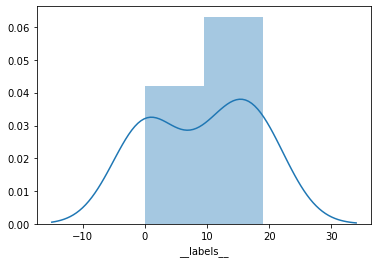

In [108]:
sns.distplot(selected_data[selected_data["rec"] > 0]["__labels__"])

LinAlgError: singular matrix

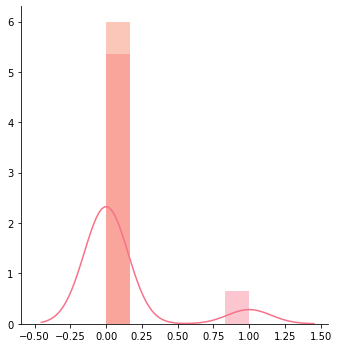

In [110]:
plot_pdf(selected_data, "rec")

In [111]:
selected_data.to_csv('selected_data.csv')

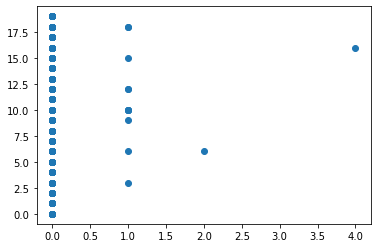

In [40]:
plt.scatter(doc_vectors[:, 0], labels[labels])